## Workflow

### 1. Setup and Authentication
- Import required libraries
- Load API key from environment variables
- Authenticate and fetch your Prolific researcher ID

In [1]:
import json
import os
import uuid
import requests
from zoneinfo import ZoneInfo
from datetime import datetime, timezone
from dotenv import load_dotenv
from io import StringIO

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load environment variables
# load_dotenv()
# prolific_token = os.getenv("PROLIFIC_TOKEN")

# Use Colab secrets to add API token --> Tutorial: https://www.youtube.com/watch?v=LPa51KxqUAw
from google.colab import userdata
prolific_token = userdata.get('PROLIFIC_TOKEN')
prolific_workspace = userdata.get('PROLIFIC_WORKSPACE_ID')
prolific_project = userdata.get('PROLIFIC_PROJECT_ID')

In [3]:
# Set up headers for authenticated requests to the Prolific API
headers = {
    "Authorization": f"Token {prolific_token}",
    "Content-Type": "application/json",
}

In [4]:
# Fetch your Prolific researcher ID
res = requests.get("https://api.prolific.com/api/v1/users/me/", headers=headers)
researcher_id = res.json()["id"]

### 2. Survey Creation

In [ ]:
# Build survey question
question_text = (
    f"Do you think the new iPhone organge color would go well with a pink phone case?"
)
print(question_text)

Do you think the new iPhone organge color would go well with a pink phone case?


In [ ]:
# Generate UUIDs for question and answers
section_id = str(uuid.uuid4())
question_id = str(uuid.uuid4())
answer_1_id = str(uuid.uuid4())
answer_2_id = str(uuid.uuid4())
answer_3_id = str(uuid.uuid4())

In [ ]:
# Build the payload
survey_data = {
    "researcher_id": researcher_id,
    "title": "One question about the new iPhone color",
    "sections": [
        {
            "id": section_id,
            "title": "Do you think the new iPhone organge color would go well with a pink phone case?",
            "questions": [
                {
                    "id": question_id,
                    "title": question_text,
                    "type": "single",
                    "answers": [
                        {"id": answer_1_id, "value": "Yes, it would look great!"},
                        {"id": answer_2_id, "value": "No, it would look bad!"},
                        {"id": answer_3_id, "value": "I don't care"},
                    ],
                }
            ],
        }
    ],
    "questions": [  # Flat list of questions (same structure)
        {
            "id": question_id,
            "title": question_text,
            "type": "single",
            "answers": [
                {"id": answer_1_id, "value": "Yes, it would look great!"},
                {"id": answer_2_id, "value": "No, it would look bad!"},
                {"id": answer_3_id, "value": "I don't care"},
            ],
        }
    ],
}

In [ ]:
response = requests.post(
    "https://api.prolific.com/api/v1/surveys/",
    headers=headers,
    data=json.dumps(survey_data)
)

print(response.status_code)

201


In [ ]:
survey_id = response.json()["_id"]

### 3. Study Configuration
- Set study parameters (configurable):
  - Reward: $1 per participant
  - Participants: 20
  - Estimated time: 1 minute
- Generate completion codes and filters

In [ ]:
study_config = {
    "reward": 1,
    "participants": 20,
    "estimated_time": 1,
    "max_time": 2,
}

### 4. Study Publication
- Create the study with all parameters
- Publish it to make it available to participants
- Monitor study status and participant recruitment

In [ ]:
completion_code = f"AI_DAILYLIFE_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

In [ ]:
# Build the study payload
study_data = {
    "name": f"One question about the new iPhone color",
    "internal_name": f"iPhone color survey {datetime.now().strftime('%Y%m%d_%H%M%S')}",
    "description": "One question about the new iPhone color",
    "external_study_url": f"https://prolific.com/surveys/{survey_id}",
    "completion_codes": [
        {
            "code": completion_code,
            "code_type": "COMPLETED",
            "actions": [{"action": "AUTOMATICALLY_APPROVE"}],
        }
    ],
    "estimated_completion_time": study_config["estimated_time"],
    "max_time": study_config["max_time"],
    "reward": int(study_config["reward"] * 100),  # convert to cents
    "total_available_places": study_config["participants"],
    "device_compatibility": ["desktop", "tablet", "mobile"],
    "peripheral_requirements": [],
    "privacy_notice": "Your data will be used for research purposes only and will be kept confidential.",
    "project": prolific_project
}

In [ ]:
# Create draft study
study_response = requests.post(
    "https://api.prolific.com/api/v1/studies/",
    headers=headers,
    data=json.dumps(study_data)
)

study_response.status_code

201

In [ ]:
study_id = study_response.json().get("id")

In [ ]:
# Publish study
publish_response = requests.post(
        f"https://api.prolific.com/api/v1/studies/{study_id}/transition/",
        headers=headers,
        data=json.dumps({"action": "PUBLISH"})
    )

In [ ]:
publish_response.status_code

200

# RESULTS
- Monitor participant submissions
- Export results in CSV format
- Load data into pandas DataFrame for analysis
- Calculate completion times and response statistics

In [ ]:
def show_study_results(study_id: str, headers: dict):
    """
    Fetch and display Prolific study info, latest response, and completion duration.
    All displayed times are shown in Europe/London.
    """

    # --- Get study details ---
    study_url = f"https://api.prolific.com/api/v1/studies/{study_id}/"
    study_response = requests.get(study_url, headers=headers)
    study_response.raise_for_status()
    study_info = study_response.json()

    status = study_info.get("status")
    name = study_info.get("name")
    total_places = study_info.get("total_available_places")
    total_places_taken = study_info.get("places_taken")

    # Parse published_at as UTC, then convert to San Francisco for display
    published_iso = study_info.get("published_at")  # e.g. "2025-09-29T13:08:00Z"
    created_at_utc = datetime.fromisoformat(published_iso.replace("Z", "+00:00")).astimezone(timezone.utc)
    created_at_sf = created_at_utc.astimezone(ZoneInfo("America/Los_Angeles"))

    # --- Print basic study info (London time) ---
    print(f"✅ Study Name: {name}")
    print(f"📊 Status: {status}")
    print(f"👥 Total Places: {total_places}")
    print(f"📩 Total Submissions: {total_places_taken}")
    print(f"⏳ Created at: {created_at_sf.strftime('%d %b %Y, %I:%M %p %Z')}")

    # --- Get response exports ---
    responses_url = f"https://api.prolific.com/api/v1/studies/{study_id}/export/"
    resp = requests.get(responses_url, headers=headers)
    resp.raise_for_status()
    df = pd.read_csv(StringIO(resp.text))

    if "Completed at" not in df.columns:
        print("⚠️ 'Completed at' column not found in export.")
        return df

    # --- Process completion times ---
    completed_times = pd.to_datetime(df["Completed at"], errors="coerce", utc=True)
    latest_completion_utc = completed_times.dropna().max()

    if pd.isna(latest_completion_utc):
        print("⚠️ No completions yet.")
        return df

    latest_completion_sf = latest_completion_utc.tz_convert(ZoneInfo("America/Los_Angeles"))
    print(f"🕒 Last Response At: {latest_completion_sf.strftime('%d %b %Y, %I:%M %p %Z')}")

    # --- Compute duration (use UTC to avoid DST pitfalls), display in minutes ---
    duration_minutes = (latest_completion_utc - created_at_utc).total_seconds() / 60
    print(f"⏱️ Time Lapsed: {duration_minutes:.0f} minutes")

    return df

In [ ]:
df = show_study_results(study_id, headers)

✅ Study Name: One question about the new iPhone color
📊 Status: ACTIVE
👥 Total Places: 20
📩 Total Submissions: 12
⏳ Created at: 29 Oct 2025, 07:13 PM PDT
🕒 Last Response At: 29 Oct 2025, 07:16 PM PDT
⏱️ Time Lapsed: 3 minutes


In [ ]:
df.head()

,Submission id,Participant id,Status,Custom study tncs accepted at,Started at,Completed at,Reviewed at,Archived at,Time taken,Completion code,...,Student status,Employment status,Long-term health condition/disability,Fluent languages,Sexual orientation,Highest education level completed,Degree subject,Work role,Submission approval rate,Do you think the new iPhone organge color would go well with a pink phone case?
0,6902c9dd0e1ffba0bb1453c3,62f975cbc3507ecf77180d00,AWAITING REVIEW,Not Applicable,2025-10-30T02:13:51.195000Z,2025-10-30T02:14:17.673000Z,NaN,2025-10-30T02:14:18.078000Z,27,NOCODE,...,DATA_EXPIRED,DATA_EXPIRED,No,English,DATA_EXPIRED,DATA_EXPIRED,DATA_EXPIRED,DATA_EXPIRED,100,"No, it would look bad!"
1,6902c9eb1ae8ed7baf7ce224,65c1bd40f77b5db9d93030b0,AWAITING REVIEW,Not Applicable,2025-10-30T02:14:04.742000Z,2025-10-30T02:14:24.405000Z,NaN,2025-10-30T02:14:24.844000Z,20,NOCODE,...,No,Full-Time,Yes,"German, Turkish, English",heterosexual,Graduate degree (MA/MSc/MPhil/other),"Engineering, manufacturing and construction",Manager,100,"No, it would look bad!"
2,6902ca122ee9f7189961d070,646e12b8cca43e4c726c45be,AWAITING REVIEW,Not Applicable,2025-10-30T02:14:46.600000Z,2025-10-30T02:16:17.788000Z,NaN,2025-10-30T02:16:18.247000Z,92,NOCODE,...,DATA_EXPIRED,DATA_EXPIRED,Yes,English,DATA_EXPIRED,DATA_EXPIRED,DATA_EXPIRED,DATA_EXPIRED,100,"Yes, it would look great!"
3,6902ca198d909200543039f8,669a7bf765ea1aa5d1389dd9,AWAITING REVIEW,Not Applicable,2025-10-30T02:14:52.816000Z,2025-10-30T02:15:22.682000Z,NaN,2025-10-30T02:15:23.166000Z,30,NOCODE,...,DATA_EXPIRED,DATA_EXPIRED,DATA_EXPIRED,"Japanese, English, Croatian, Portuguese",heterosexual,DATA_EXPIRED,Arts & Humanities,DATA_EXPIRED,100,"Yes, it would look great!"
4,6902ca38daf8f65bff9deaac,65f25f148039424910f7fb79,AWAITING REVIEW,Not Applicable,2025-10-30T02:15:23.893000Z,2025-10-30T02:15:36.342000Z,NaN,2025-10-30T02:15:36.779000Z,13,NOCODE,...,No,Full-Time,No,"Vietnamese, English",heterosexual,Undergraduate degree (BA/BSc/other),"Engineering, manufacturing and construction",Senior Manager,100,"Yes, it would look great!"


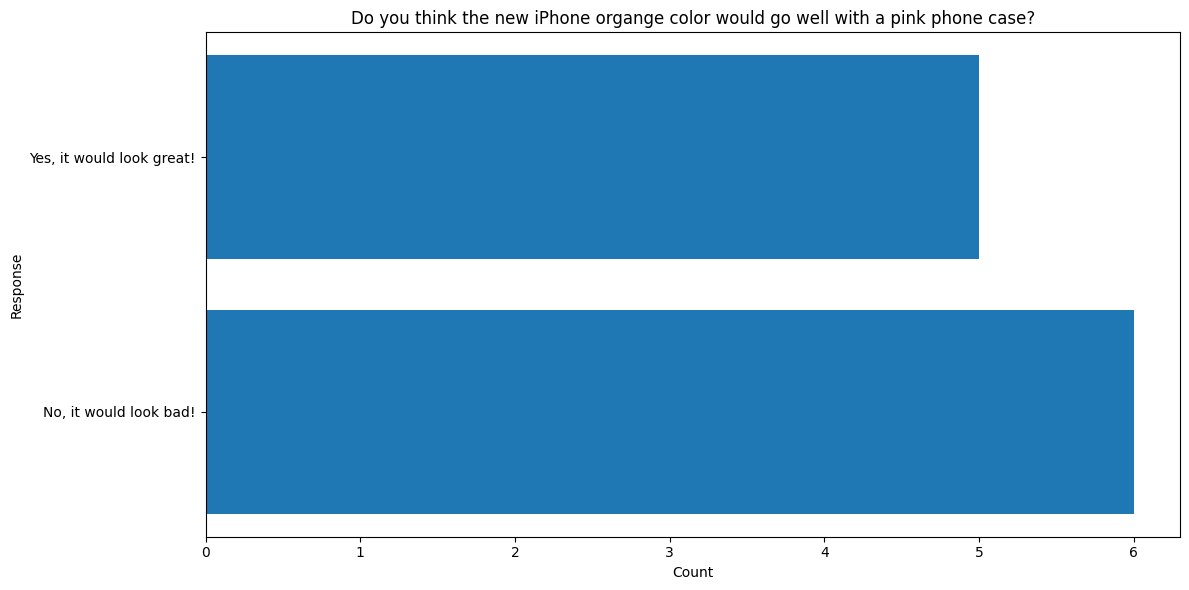

In [ ]:
from textwrap import fill

col = "Do you think the new iPhone organge color would go well with a pink phone case?"
response_counts = (
    df[col]
    .dropna()
    .astype(str)
    .value_counts()
    .sort_values(ascending=True)
)


labels_wrapped = [fill(lbl, width=32) for lbl in response_counts.index]


height = max(6, 0.6 * len(response_counts))
fig, ax = plt.subplots(figsize=(12, height))


ax.barh(labels_wrapped, response_counts.values)


ax.set_title(col, wrap=True)
ax.set_xlabel("Count")
ax.set_ylabel("Response")

ax.invert_yaxis()


fig.tight_layout()
plt.show()